# Trajectories That Follow Ocean Currents

For documentation see:

- <https://JuliaClimate.github.io/IndividualDisplacements.jl/dev/>
- <https://en.wikipedia.org/wiki/Displacement_(vector)>
- <https://JuliaClimate.github.io/MeshArrays.jl/dev/>
- <https://docs.juliadiffeq.org/latest>

This notebook requires downloading `nctiles_climatology/` from e.g. [ftp://mit.ecco-group.org/ecco_for_las/version_4/release2/nctiles_climatology/]() as follows:

```
run(`wget --recursive ftp://mit.ecco-group.org/ecco_for_las/version_4/release2/nctiles_climatology`)
run(`mv mit.ecco-group.org/ecco_for_las/version_4/release2/nctiles_climatology ../inputs/`)
```

## 1. import software

In [2]:
using IndividualDisplacements, MeshArrays, OrdinaryDiffEq
using Plots, Statistics, MITgcmTools, DataFrames

## 2. Read gridded variables

Put grid variables in a dictionary.

In [3]:
if !isdir("../inputs/GRID_LLC90")
    run(`git clone https://github.com/gaelforget/GRID_LLC90 ../inputs/GRID_LLC90`)
end

mypath="../inputs/GRID_LLC90/"
mygrid=GridSpec("LatLonCap",mypath) 
GridVariables=GridLoad(mygrid)
GridVariables=merge(GridVariables,
    IndividualDisplacements.NeighborTileIndices_cs(GridVariables));

Read velocity fields as `MeshArray`s.

In [4]:
pth="../inputs/nctiles_climatology/"
msg="Please download $pth from e.g. `ftp://mit.ecco-group.org/ecco_for_las/version_4/release2/`"
!isdir("$pth"*"UVELMASS") ? error(msg) : nothing
!isdir("$pth"*"VVELMASS") ? error(msg) : nothing

fileName="../inputs/nctiles_climatology/UVELMASS/UVELMASS"
u=Main.read_nctiles(fileName,"UVELMASS",mygrid)
fileName="../inputs/nctiles_climatology/VVELMASS/VVELMASS"
v=Main.read_nctiles(fileName,"VVELMASS",mygrid)
show(u)

 gcmarray 
  grid type   = LatLonCap
  data type   = Float64
  tile array  = (5, 50, 12)
  tile sizes  = (90, 270)
                (90, 270)
                (90, 90)
                (270, 90)
                (270, 90)


Select depth & time, normalize to grid units, and apply exchange.

In [5]:
#u=dropdims(mean(u,dims=3),dims=3)
#v=dropdims(mean(v,dims=3),dims=3)

u=u[:,20,1]
v=v[:,20,1]
msk=(GridVariables["hFacC"][:,20] .> 0.)

u[findall(isnan.(u))]=0.0
v[findall(isnan.(v))]=0.0

u=u./GridVariables["DXC"]#normalization to grid units
v=v./GridVariables["DYC"]

(u,v)=exchange(u,v,1)#add 1 point at each edge for u and v

u0=u; u1=u; v0=v; v1=v;

Put everything in a dictionary.

In [6]:
t0=0.0; t1=86400*366*10.0; dt=10*86400.0;

uvt = Dict("u0" => u0, "u1" => u1, "v0" => v0, "v1" => v1,
    "t0" => t0, "t1" => t1, "dt" => dt, "msk" => msk)

uvetc=merge(uvt,GridVariables);

Get lon and lat array with added columns and rows

In [7]:
XC=exchange(GridVariables["XC"])
YC=exchange(GridVariables["YC"])

show(XC)

 gcmarray 
  grid type   = LatLonCap
  data type   = Float64
  tile array  = (5,)
  tile sizes  = (92, 272)
                (92, 272)
                (92, 92)
                (272, 92)
                (272, 92)


## 3. Compute trajectories

Set `comp_vel`, an alias, to a suitable function.

In [8]:
comp_vel=IndividualDisplacements.VelComp!

VelComp! (generic function with 2 methods)

Define `uInitS`, the initial condition array

In [9]:
uInitS = Array{Float64,2}(undef, 3, prod(XC.grid.ioSize))
kk = 0

for fIndex = 1:5
        nx, ny = XC.fSize[fIndex]
        ii1 = 0.5:1.0:nx
        ii2 = 0.5:1.0:ny
        n1 = length(ii1)
        n2 = length(ii2)
        for i1 in eachindex(ii1)
          for i2 in eachindex(ii2)
            if msk[fIndex][Int(round(i1+0.5)),Int(round(i2+0.5))]
                        global kk += 1
                        let kk = kk
                                uInitS[1, kk] = ii1[i1]
                                uInitS[2, kk] = ii2[i2]
                                uInitS[3, kk] = fIndex
                        end
            end
          end
        end
end

uInitS=uInitS[:,1:kk]
du=fill(0.0,size(uInitS));

Solve for all trajectories.

In [10]:
tspan = (0.0,uvt["t1"]-uvt["t0"])
prob = ODEProblem(comp_vel,uInitS,tspan,uvetc)
sol = solve(prob,Euler(),dt=uvt["dt"])
size(sol)

(3, 54408, 367)

## 4. Plot trajectories

- Copy `sol` to a `DataFrame`

In [11]:
ID=collect(1:size(sol,2))*ones(1,size(sol,3))
x=sol[1,:,:]
y=sol[2,:,:]
fIndex=sol[3,:,:]
df = DataFrame(ID=Int.(ID[:]), x=x[:], y=y[:], fIndex=fIndex[:])
size(df)

(19967736, 4)

- Map i,j position to lon,lat coordinates

In [12]:
lon=Array{Float64,1}(undef,size(df,1))
lat=similar(lon)

for ii=1:length(lon)

#get location in grid index space
x=df[ii,:x]; y=df[ii,:y]; fIndex=Int(df[ii,:fIndex])
dx,dy=[x - floor(x),y - floor(y)]
i_c,j_c = Int32.(floor.([x y])) .+ 2

#interpolate lon and lat to position
tmp=view(YC[fIndex],i_c:i_c+1,j_c:j_c+1)
lat[ii]=(1.0-dx)*(1.0-dy)*tmp[1,1]+dx*(1.0-dy)*tmp[2,1]+
(1.0-dx)*dy*tmp[1,2]+dx*dy*tmp[2,2]

tmp=view(XC[fIndex],i_c:i_c+1,j_c:j_c+1)
if (maximum(tmp)>minimum(tmp)+180)&&(lat[ii]<88)
        tmp1=deepcopy(tmp)
        tmp1[findall(tmp.<maximum(tmp)-180)] .+= 360.
        tmp=tmp1
end
#kk=findall(tmp.<maximum(tmp)-180); tmp[kk].=tmp[kk].+360.0
lon[ii]=(1.0-dx)*(1.0-dy)*tmp[1,1]+dx*(1.0-dy)*tmp[2,1]+
(1.0-dx)*dy*tmp[1,2]+dx*dy*tmp[2,2]
end

df.lon=lon
df.lat=lat

show(df[end-3:end,:])

4×6 DataFrame
│ Row │ ID    │ x       │ y       │ fIndex  │ lon      │ lat      │
│     │ Int64 │ Float64 │ Float64 │ Float64 │ Float64  │ Float64  │
├─────┼───────┼─────────┼─────────┼─────────┼──────────┼──────────┤
│ 1   │ 54405 │ 227.643 │ 85.9626 │ 5.0     │ -42.7212 │ -77.3718 │
│ 2   │ 54406 │ 228.307 │ 85.9251 │ 5.0     │ -42.8687 │ -77.6176 │
│ 3   │ 54407 │ 229.333 │ 86.8708 │ 5.0     │ -42.0286 │ -78.0164 │
│ 4   │ 54408 │ 228.72  │ 89.0268 │ 5.0     │ -39.6063 │ -77.834  │

- call `PlotMapProj` or `PlotMakie`

┌ Info: Precompiling Makie [ee78f7c6-11fb-53f2-987a-cfe4a2b5a57a]
└ @ Base loading.jl:1242


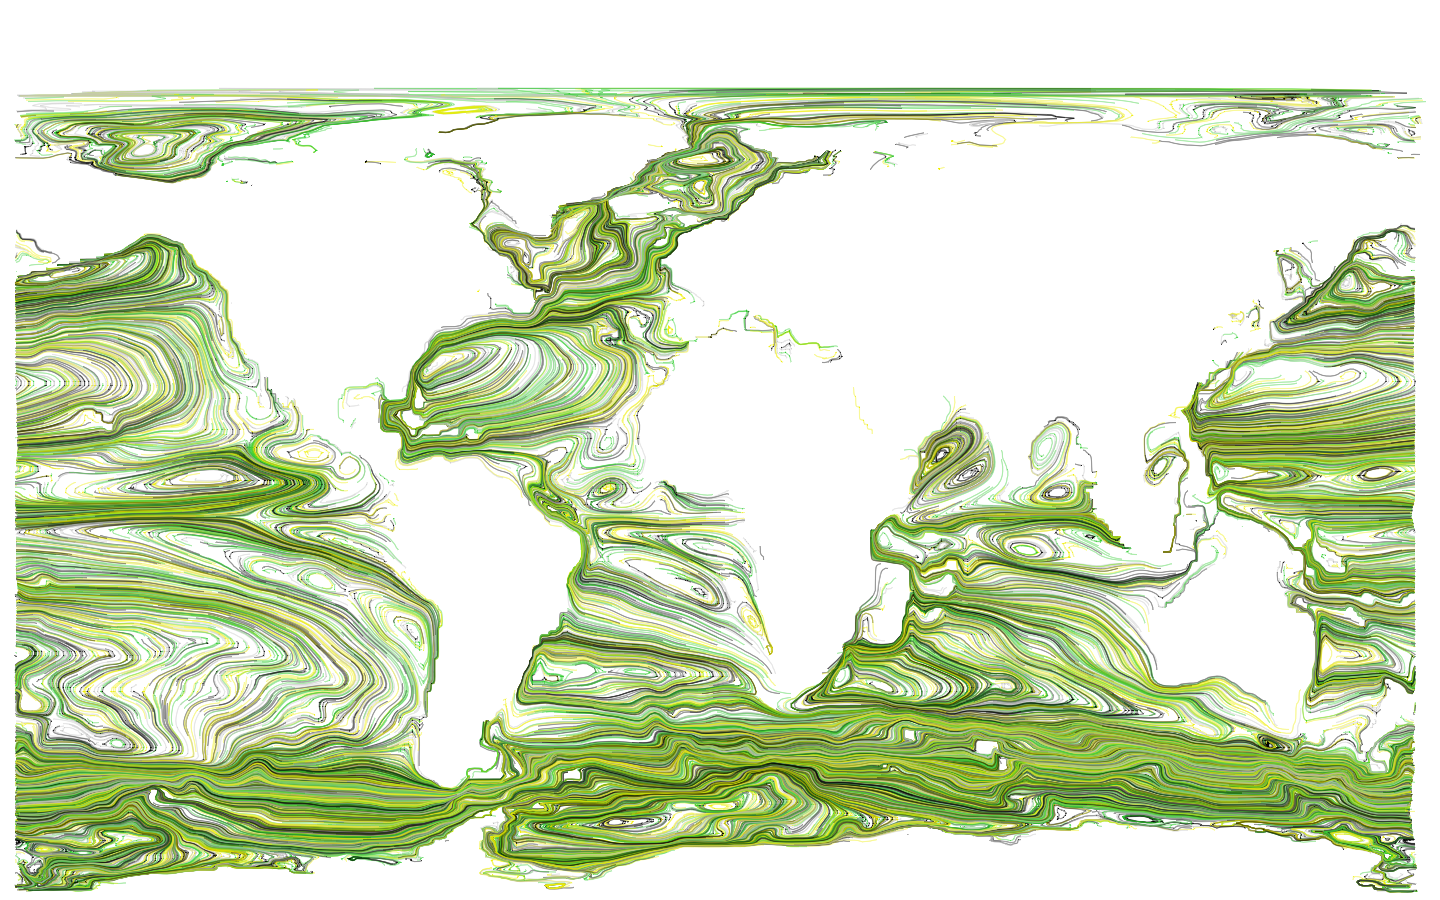

┌ Warning: Showing scene as text. This happens because `AbstractPlotting.inline!(true)` is set.
│ This needs to be false to show a plot in a window when in the REPL.
└ @ AbstractPlotting /Users/gforget/.julia/packages/AbstractPlotting/AO27s/src/display.jl:114


In [13]:
p=dirname(pathof(IndividualDisplacements))

nn=10000

#include(joinpath(p,"plot_pyplot.jl"))
#PyPlot.figure(); PlotMapProj(df,nn)

include(joinpath(p,"plot_makie.jl"))
AbstractPlotting.inline!(true) #for Juno, set to false
scene=PlotMakie(df,nn,180.0)
#Makie.save("LatLonCap300mDepth.png", scene)